# REINFORCEMENT LEARNING PROJECT 

In [7]:
# Importations

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm
import copy
import time
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
import tensorflow as tf
from collections import deque, namedtuple
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Dense, Embedding, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
import pickle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



## Define the Plot functions and the ones used for initialisation


In [99]:

def creation_u(n_states) :
    # Creates a matrix u of related content
    u = np.array([ [random.uniform(0,1) for i in range(n_states)] for j in range(n_states)])
    np.fill_diagonal(u, 0)

    return np.array(u)

def creation_caching(n_states, n_cached) :
    # Returns a list which contains the cost to get a content
    # It contains only 0 (cached) or 1 (non-cached)
    cost = np.array([1 for i in range(n_states)])
    index = list(random.sample(range(0, n_states), n_cached))
    for x in index :
        cost[x] = 0
    return np.array(cost)


def create_priori_popularity(n_states,uniform = True) :
    # It creates a list of probability to get the content
    # This is p_0 = [ p_0, ..., p_K-1]
    # The sum should be one
    if uniform : 
        result = (1/n_states) * np.ones((1,n_states))[0]
    else :
        result = [random.random() for i in range(1,n_states)]
        sum_r = np.sum(result)
        result = [i/sum_r for i in result]
        result = np.array(result)
    return result


def get_random_state(p0) :
    # Returns a random content among the contents
    state = [i for i in range(len(p0))]
    
    return np.random.choice(state,1,p0[0])[0]

def get_recommended(state,n_recommended,u) :
    # Returns the n_recommended content of the content 'state'
    # For the moment we only return the most related contents
    liste = u[state]
    not_null = len(np.where(liste != 0)[0])
    indx = (-liste).argsort()[:min(not_null, n_recommended)]
    return np.array(indx)

def get_cached(state, cost):
    # Takes as input a state and the cost matrix (where Xi = 0 if cached and 1 if not-cached)
    # Returns a boolean which says whether or not it is cached or not
    return cost[state] == 0


def running_mean(x, N):
    # Compute the running mean of size N

    mask=np.ones((1,N))/N
    mask=mask[0,:]
    result = np.convolve(x,mask,'same')

    return result



def plot_q_table(q_table) :
    # Plot the q_table 
    ax = plt.subplot(111)
    im = ax.imshow(q_table)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.ylabel("States")
    plt.xlabel("Actions")
    plt.title("Q table")
    plt.colorbar(im, cax=cax)

    plt.show()


def get_q_table_gamma(gamma_q_tables, gammas) :
    liste_title = ['Gamma = {:.2f}'.format(i) for i in gammas]
    plot_multiple(gamma_q_tables,4,3, "Actions", "States",\
                           "Q table for different values of gamma" ,\
                       liste_titles= liste_title,sizes = (10,10))

def get_matrix_rewards(env) :
    # Compute the reward for each state and action
    q_table = np.zeros((env.n_states,env.n_actions))
    index_cached = np.where(env.get_index_cached() == 0)[0]
    index_recommended = env.get_index_recommendation()
    q_table[:,index_cached] += 1
    for index,x in enumerate(index_recommended) :
        q_table[index][x] +=1

    return q_table


def plot_multiple(matrices,Nr,Nc, x_label, y_label,title, liste_titles,sizes = (12,12), cmap = 'viridis') :
    

    fig, axs = plt.subplots(Nr, Nc, figsize=sizes)
    fig.suptitle(title)

    images = []
    
    axs = axs.reshape(-1,1)
    
    for k,ax in enumerate(axs) : 
        images.append(ax[0].imshow(matrices[k], cmap=cmap))
        ax[0].label_outer()
        ax[0].set_xlabel(x_label)
        ax[0].set_ylabel(y_label)
        ax[0].set_title(liste_titles[k], fontsize = 12)
            

    vmin = 0
    vmax = 2
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in images:
        im.set_norm(norm)

    fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.05)
    plt.show()



def get_q_table_gamma(gamma_q_tables, gammas) :
    liste_title = ['Gamma = {:.2f}'.format(i) for i in gammas]
    plot_multiple(gamma_q_tables,4,3, "Actions", "States",\
                           "Q table for different values of gamma" ,\
                       liste_titles= liste_title,sizes = (10,10))

def get_final_table(q_table, binary = True) :
    # Retuns the final recommendation which is the policy
    indexes_max = get_max_q_table(q_table)
    final_table = np.zeros(q_table.shape)
    for index,x in enumerate(indexes_max) :
        for y in x:
            if binary :
                final_table[index,y ] = 1
            else :
                final_table[index,y ] = q_table[index,y ]


    return final_table


    
def compare_algo(env, q_table, policy, cmap, name=None ) :
    
    final_table = get_final_table(q_table, binary = True)
    
    
    to_plot = [policy,final_table, get_matrix_rewards(env),\
              policy + final_table]
    titles = ["Policy with paper algorithm","Policy with RL algorithm", 'Reward matrix','Sum of two policies']
    plot_multiple(to_plot, 2,2, "Actions", "States","", titles,sizes = (8,8), cmap=cmap)
    similarity = np.where(policy + final_table == 2 )[0].shape[0]/ q_table.shape[0]
    print("Similarity between Paper algorithm and RL algorithm : {}".format(similarity))
    
    
    
def get_max_q_table(q_table) :
    # Returns a list of indexes of the max of the q_table
    liste_index = []
    for i in range(q_table.shape[0]) :
        maxm = np.max(q_table[i])
        indexes = np.where(q_table[i] == maxm)[0]
        liste_index.append(indexes)

    return liste_index



## The environment 

In [62]:

class Environment(object) :
    # Creates an environmnent
    # For us, this is the behavior of the User
    def __init__(self,n_actions,  n_states, alpha, to_leave, n_recommended, n_cached,\
                rewards,SEED=5, u=None) :
        self.SEED = SEED
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        # Alpha is the coefficient in which a user chooses a recommended content
        self.to_leave = to_leave
        # to_leave is the coefficient in which a user decides to quit the process
        #self.state = np.array([i for i in range(n_states)])
        self.n_recommended = n_recommended
        # n_recommend corresponds to the number of content to recommend. HERE, WE DON'T USE IT YET
        self.n_cached = n_cached
        # n_cached correponds to the number of cached content
        #self.index_recommended = create_matrix_u(self.n_states,self.n_actions,self.n_recommended)
        #self.index_cached = create_matrix_u(self.n_states,self.n_actions,self.n_cached)
        self.u = creation_u(self.n_states) if u is None else u  
        # U matrix which denotes the similarity score
        self.cost = creation_caching(self.n_states, self.n_cached)
        # It denotes the cached content (0 if cached, 1 not-cached)
        self.p0 = create_priori_popularity(self.n_states)
        # The probability to choose content j from the catalogue
        self.rewards = rewards
        # List of rewards like [RC, RnC , nRC, nRnC]
        # RC = Recommended & Cached ; nRnC = non Recommended & non Cached
        self.recommended = self.get_index_recommendation()
        
    def refresh(self,SEED = None) :
        # Reset the state to a new value
        if SEED is not None :
            self.SEED = SEED
        return random.randrange(0,self.n_states,1)
    
    def reset(self) :
        # Reset the environment to a new random state. 
        #It resets both the recommendation and the cached indexes
        # It returns a first state
        self.u = creation_u(self.n_states)
        self.cached = creation_caching(self.n_states, self.n_cached)
        self.p0 = create_priori_popularity(self.n_states)
    
        return self.state[random.randrange(0,self.n_states,1)]

    
    
    def find_reward(self, action,state) :
        # Finds the reward for the given action starting in the given state 
        # It tests whether the state is recommended, cached or not
        
        # It gives from the u matrix whether the action from the state is recommended or not
        if ((state is None) or (action is None) ):
            return None
        
        recommended_matrix = self.recommended[state]
        is_cached = get_cached(action, self.cost)
        
        if ( (action in recommended_matrix) and (is_cached)) :
            # Content recommended and cached : best reward
            return self.rewards[0]
        elif ( (action in recommended_matrix) and ( not is_cached) ) :
            # Content recommended but not cached
            return self.rewards[1]
        elif ( (action not in recommended_matrix ) and (is_cached)) :
            # Content not recommended but cached
            return self.rewards[2]
        else :
            # Content neither recommended nor cached
            return self.rewards[3]
    
    
    def step(self, action,state) :
        # Returns the state, reward after taking the action in input
        # done is a boolean to say whether the user quits the game or not
        # We want to return the state where will be the user when we suggest him "action"
        # Knowing he is in the current 'state'

        if (random.uniform(0, 1) < self.to_leave) :
            # The user stops to play
            reward = self.find_reward(action,state)
            new_state,reward, done = None,reward,True
            return new_state,reward, done
        else :

            # Else the user will choose among the contents
            if (random.uniform(0,1)< self.alpha ) :

                # Then the user chooses a content among the recommended contentss
                new_state = action
                reward = self.find_reward(action,state)
            else :
                # The user picks a content randomly in the catalogue

                new_state = get_random_state(self.p0)
                reward = self.find_reward(action,state)


            done = False

        if (action == state ) :
            return self.step(action, state)
        else :
            return new_state, reward, done
    
    def get_index_recommendation(self) :
        # Returns a matrix with all index of recommended content
        recommended = []
        for state in range(self.n_actions) :
            recommended.append(get_recommended(state,self.n_recommended,self.u))
        return recommended
    
    def get_index_cached(self) :
        
        return self.cost
    


# Q learning algorithm 


In [63]:
def q_learning(env,alpha,gamma,epsilon,max_iter,v1=True, threshold = 0.1) :

    # Alpha : learning rate
    # Gamma : Long-term reward
    # Epsilon-greedy : do we exploit or explore
    # Max_iter : the number of episode maximum
    # v1 : If true, no restriction on the contents we search. Otherwise, just search among the related contents 
    
    """Training the agent"""
    # Initialisation of the q_table
    q_table = np.zeros([env.n_states, env.n_actions])
    
    # For plotting metrics
    q_table_diff = []
    max_diff = threshold + 1
    i=0
    
    before_time = time.time()
    while( (i < max_iter) and (max_diff > threshold)) :
        # We copy the first step of the table to compare at the end
        before_q = copy.copy(q_table)

        # Initialize the state
        state = env.refresh()
        # Initialization of the variables
        # Penalties aims to show how will evolve the average reward through the process
        epochs= 0

        # The boolean which says whether the process is done or not
        done = False
        
        while not done :

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                if v1 :
                    action = random.randint(0,env.n_actions-1)
                else :
                    recommended_contents =  env.recommended[state]
                    index_state = random.randrange(0,len(recommended_contents),1)
                    action = recommended_contents[index_state]           
            else :
                # Exploit learned values
                action = np.argmax(q_table[state])
               
            # Go to the next state
            next_state, reward, done = env.step(action,state)

            if ( (next_state is None) or (action is None)  ) :
                # We stop when the user leaves the process
                break

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Q learning algorithm

            new_value = (1- alpha)* old_value + alpha * (reward + gamma * next_max)
            q_table[state,action] = new_value
            # Just compute the penalty by hand to see how well is our decision

            # Go to the next state
            state = next_state
            epochs +=1
                
        i+=1
        
        q_table_diff.append((q_table - before_q).max()    )

        if i%1000 == 0 :
            max_diff =  np.mean(q_table_diff) 
            q_table_diff = []
            
        if i%10000 == 0 :
            
            print('Episode : {}'.format(i))
            clear_output(True)
        
    
    time_train =  time.time() - before_time
    return (1-gamma) * q_table, time_train, i


### Exemple of use 

In [64]:
# Load the environment 
with open('./utils/env.pickle', 'rb') as f:
    env = pickle.load(f)


In [65]:
# env = Environment(n_actions=100,n_states=100,alpha=0.6, to_leave=0.1, n_recommended=10,\
#                  n_cached=20,rewards=[10,5,5,-5],SEED=77)

In [66]:
q_table, time_train , epoch = q_learning(env,alpha=0.6 ,gamma = 0,\
                                                    epsilon=0.1,max_iter = 100000,v1=True, threshold = 0.005)

Episode : 20000


In [67]:
q_table_constraints, time_train_constraints , epoch_constraints = q_learning(env,alpha=0.6 ,gamma = 0,\
                                                    epsilon=0.1,max_iter = 100000,v1=False, threshold = 0.005)

#### Plot the q_table 

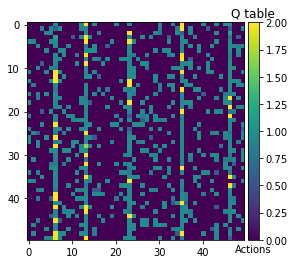

Time to converge : 6.0746588706970215 s
Number of epochs : 20000 


In [68]:
# No constraints
plot_q_table(q_table)
print('Time to converge : {} s\nNumber of epochs : {} '.format(time_train,epoch))

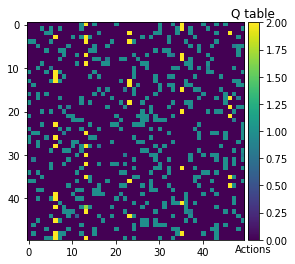

Time to converge : 2.0527427196502686 s
Number of epochs : 7000 


In [69]:
plot_q_table(q_table_constraints)
print('Time to converge : {} s\nNumber of epochs : {} '.format(time_train_constraints,epoch_constraints))

#### Plot the reward matrix 

The reward matrix is just the matrix tha summarises the reward whenever the value is related or cached

Whenever this is cyan : related or cached

Whenever this is yellow : related and cached


Otherwise : neither recommended not cached

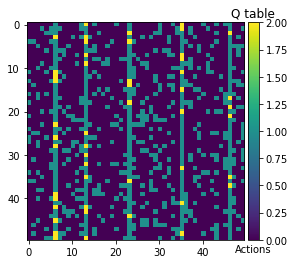

In [70]:
plot_q_table(get_matrix_rewards(env))

### Check the results for different values of gamma  

In [71]:
def loop_gamma(gammas, max_iter_g,v1=True, env = None) :
    # Run the q_learning algorithm for different values of gammas
    gamma_q_tables = []
    if env is None : 
        env = Environment(n_actions=50,n_states=50,alpha=0.6, to_leave=0.1, n_recommended=10,\
                 n_cached=10,rewards=[10,5,5,-5],SEED=777)
        
    for gamma in gammas :
        q_table, _,_ = q_learning(env,alpha = 0.2,gamma = gamma ,\
                                    epsilon = 0.1,max_iter = max_iter_g,v1=v1,threshold = 0.005)
        gamma_q_tables.append(q_table)

    return gamma_q_tables

In [72]:
gammas = [0,0.9]

### 1. Algorithm without any constraints on the recommendation

In [73]:
gamma_q_tables = loop_gamma(gammas, max_iter_g = 100000, env = env)

Episode : 100000


In [74]:
def get_q_table_gamma(gamma_q_tables, gammas) :
    liste_title = ['Gamma = {:.2f}'.format(i) for i in gammas]
    plot_multiple(gamma_q_tables,1,2, "Actions", "States",\

                  "Q table for different values of gamma" ,\
                       liste_titles= liste_title,sizes = (20,10))

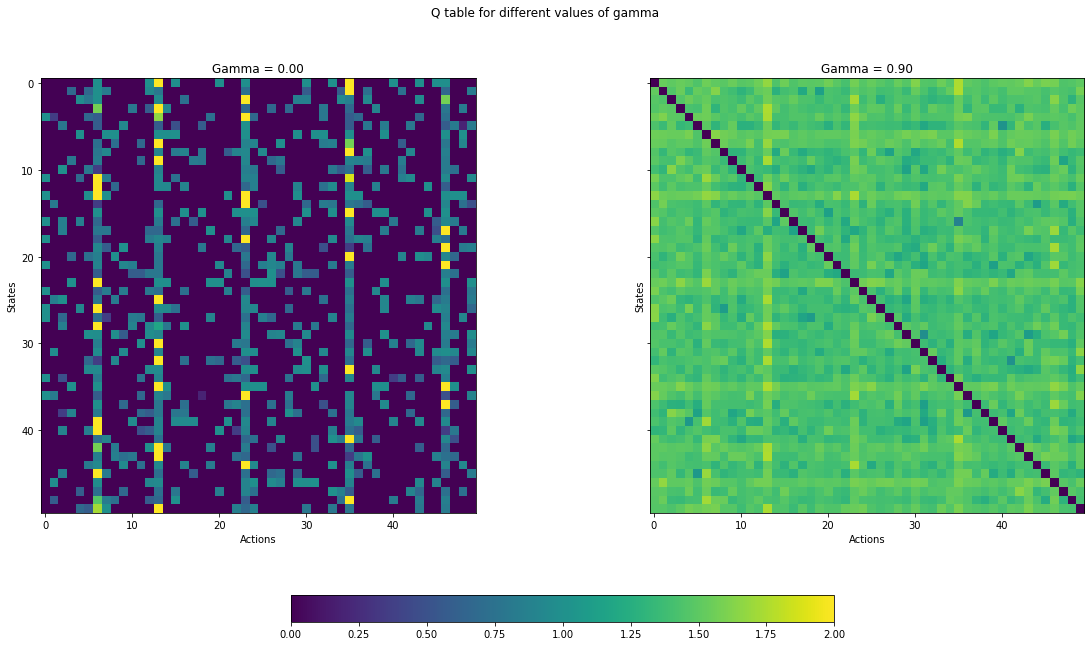

In [75]:
# Q tables for different values of gammas WITHOUT CONSTRAINTS
get_q_table_gamma(gamma_q_tables, gammas) 

### 2. Algorithm with constraints on the recommendation

In [76]:
gamma_q_tables_constraints = loop_gamma(gammas, max_iter_g = 100000, v1=False, env=env)

Episode : 100000


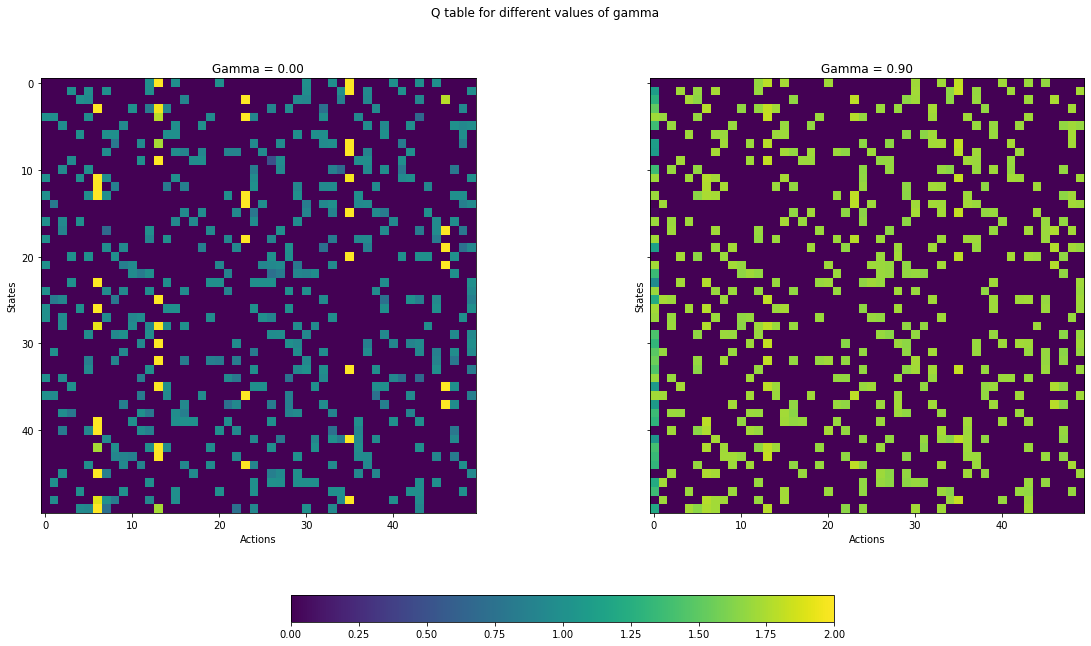

In [77]:
get_q_table_gamma(gamma_q_tables_constraints, gammas) 

## Criteria of convergence 

Note : we check the criteria of convergence of our algorithm.
To do so, we modify few lines of the previous code to see the evolution of our criteria : The max difference of q_table through the episodes/epochs

### Plot the Max difference of q table and the running mean 

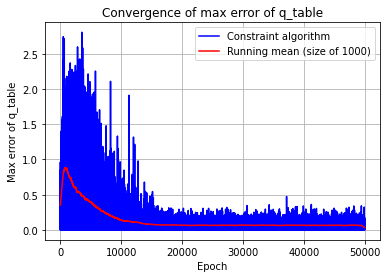

In [80]:


plt.plot(q_table_diff, color ='b', label='Constraint algorithm')
plt.plot(running_mean(q_table_diff,1000), color ='r', label='Running mean (size of 1000)')

plt.xlabel('Epoch')
plt.ylabel('Max error of q_table')
plt.title('Convergence of max error of q_table')
plt.legend()
plt.grid(True)
plt.show()





# Rewards and Penalties

In [245]:
def q_learning_rew(env,alpha,gamma,epsilon,max_iter,v1=True, threshold = 0.1) :

    # Alpha : learning rate
    # Gamma : Long-term reward
    # Epsilon-greedy : do we exploit or explore
    # v1 : Constraints or no on the related contents to recommend
    # threshold : threshold to ensure the convergence
    # Initialisation of the q_table
    q_table = np.zeros([env.n_states, env.n_actions])
    
    # For plotting metrics
    q_table_diff = []
    max_diff = threshold + 1
    i=0
    
    all_penalties , all_rewards = [],[]
    
    while( (i < max_iter) and (max_diff > threshold)) :
        # We copy the first step of the table to compare at the end
        before_q = copy.copy(q_table)

        # Initialize the state
        state = env.refresh()
        # Initialization of the variables
        # Penalties aims to show how will evolve the average reward through the process
        epochs= 0
        current_reward = 0
        current_penalty = 0
        # The boolean which says whether the process is done or not
        done = False
        
        while not done :

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                if v1 :
                    action = random.randint(0,env.n_actions-1)
                else :
                    recommended_contents =  env.recommended[state]
                    index_state = random.randrange(0,len(recommended_contents),1)
                    action = recommended_contents[index_state]           
            else :
                # Exploit learned values
                action = np.argmax(q_table[state])
               
            # Go to the next state
            next_state, reward, done = env.step(action,state)

            if ( (next_state is None) or (action is None)  ) :
                # We stop when the user leaves the process
                break

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Q learning algorithm

            new_value = (1- alpha)* old_value + alpha * (reward + gamma * next_max)
            q_table[state,action] = new_value
            # Just compute the penalty by hand to see how well is our decision

            # Go to the next state
            state = next_state
            epochs +=1
            current_reward += reward
            if reward == env.rewards[-1] : 
                current_penalty +=1
        
                
        i+=1
        
        q_table_diff.append((q_table - before_q).max()    )
        all_penalties.append(current_penalty)
        all_rewards.append(current_reward)
        
        if i%1000 == 0 :
            max_diff =  np.mean(q_table_diff) 
            q_table_diff = []
            
        
            
        if i%10000 == 0 :
            
            print('Episode : {}'.format(i))
            clear_output(True)
        
    
    return (1-gamma) * q_table, all_rewards, all_penalties

In [278]:
def loop_gamma_rew_pen(gammas,alpha,epsilon,max_iter, v1, threshold) : 
    
    rewards, penalties = [],[]
    
    env = Environment(n_actions=50,n_states=50,alpha=0.6, to_leave=0.1, n_recommended=5,\
                 n_cached=10,rewards=[2,1,1,0],SEED=777)
    
    for gamma in gammas : 
        
        _,rew,pen = q_learning_rew(env,alpha,gamma,epsilon,max_iter,v1, threshold )
        rewards.append(rew)
        penalties.append(pen)
        
    return rewards,penalties
    

In [284]:
reward_gamma, penalty_gamma = loop_gamma_rew_pen(gammas,alpha=0.2,epsilon=0.1,max_iter=100000,\
                                                 v1=True, threshold=1e-7)

Episode : 100000


In [285]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [286]:
def plot_reward_loss_gamma(reward,run_mean = 10, gammas = [0,0.9],name='Rewards') :
    # Reward : list of rewards
    # Gammas : list of gammas used
    # Run_mean : size of the window to average
    
    colors = ['r','b']
    
    for index, gamma in enumerate(gammas) : 
        
        smoothed_rews = running_mean(reward[index], run_mean)
        
        
        plt.xlabel('Epochs')
        plt.ylabel(name)
        plt.plot(smoothed_rews, color=colors[index],\
                label = r'$\gamma$ = {}, running mean : {}'.format(gamma,run_mean))
        
        
    plt.legend()
    plt.title('{} for different values of $\gamma$'.format(name))
    plt.grid(True)
    plt.show()
        

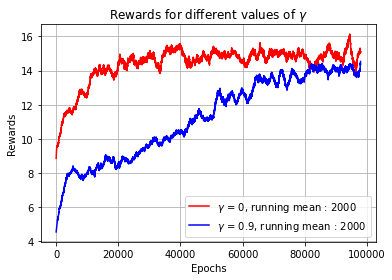

In [287]:
plot_reward_loss_gamma(reward_gamma,run_mean = 2000, gammas = [0,0.9],name = 'Rewards')

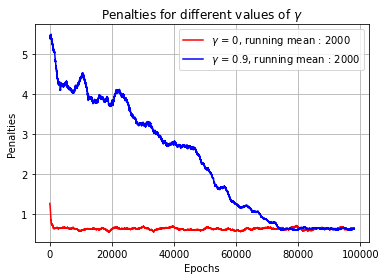

In [288]:
plot_reward_loss_gamma(penalty_gamma,run_mean = 2000, gammas = [0,0.9],name = 'Penalties')

# Comparison with a well known user

### We load the policy and u matrix from Theo's user

In [289]:
# Load the data 
annots = loadmat('utils/sim.mat')
# Get the u matrix and the policy 
u = annots['relations_matrix']

policy = annots['policy']




We change the step function to a user that chooses to consum the content j given the state i with probability : 
$$ \frac{u_{i,j}}{max(u_i)}  $$

In [290]:

class Environment_bis(object) :
    # Creates an environmnent
    # For us, this is the behavior of the User
    def __init__(self,n_actions,  n_states, alpha, to_leave, n_recommended, n_cached,\
                rewards,SEED=5, cost = None , u=None) :
        self.SEED = SEED
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        # Alpha is the coefficient in which a user chooses a recommended content
        self.to_leave = to_leave
        # to_leave is the coefficient in which a user decides to quit the process
        #self.state = np.array([i for i in range(n_states)])
        self.n_recommended = n_recommended
        # n_recommend corresponds to the number of content to recommend. HERE, WE DON'T USE IT YET
        self.n_cached = n_cached
        # n_cached correponds to the number of cached content
        #self.index_recommended = create_matrix_u(self.n_states,self.n_actions,self.n_recommended)
        #self.index_cached = create_matrix_u(self.n_states,self.n_actions,self.n_cached)
        self.u = creation_u(self.n_states) if u is None else u  
        # U matrix which denotes the similarity score
        self.cost = creation_caching(self.n_states, self.n_cached) if cost is None else cost
        # It denotes the cached content (0 if cached, 1 not-cached)
        self.p0 = create_priori_popularity(self.n_states)
        # The probability to choose content j from the catalogue
        self.rewards = rewards
        # List of rewards like [RnC , nRC, nRnC]
        # RC = Recommended & Cached ; nRnC = non Recommended & non Cached
        self.recommended = self.get_index_recommendation()
        
    def refresh(self,SEED = None) :
        # Reset the state to a new value
        if SEED is not None :
            self.SEED = SEED
        return random.randrange(0,self.n_states,1)
    
    def reset(self) :
        # Reset the environment to a new random state. 
        #It resets both the recommendation and the cached indexes
        # It returns a first state
        self.u = creation_u(self.n_states)
        self.cached = creation_caching(self.n_states, self.n_cached)
        self.p0 = create_priori_popularity(self.n_states)
    
        return self.state[random.randrange(0,self.n_states,1)]

    
    
    def find_reward(self, action,state) :
        # Finds the reward for the given action starting in the given state 
        # It tests whether the state is recommended, cached or not
        
        # It gives from the u matrix whether the action from the state is recommended or not
        if ((state is None) or (action is None) ):
            return None
        
        recommended_matrix = self.recommended[state]
        is_cached = get_cached(action, self.cost)
        
        if ( (action in recommended_matrix) and (is_cached)) :
            # Content recommended and cached : best reward
            return self.rewards[0]
        elif ( (action in recommended_matrix) and ( not is_cached) ) :
            # Content recommended but not cached
            return self.rewards[1]
        elif ( (action not in recommended_matrix ) and (is_cached)) :
            # Content not recommended but cached
            return self.rewards[2]
        else :
            # Content neither recommended nor cached
            return self.rewards[3]
    
    
    def step(self, action,state) :
        # Custom step : the user follows the recommendation with a probability uij / max(ui)
        
        if (random.uniform(0, 1) < self.to_leave) :
            # The user stops to play
            reward = 1 if action in [0,1,2] else 0

            new_state,done = None,True
            return new_state,reward, done
        else :
            
            alpha = self.u[state,action] / np.max(self.u[state,:])
            
            # Else the user will choose among the contents
            if (random.uniform(0,1)< alpha ) :
                
                # Then the user chooses a content among the recommended contentss
                new_state = action
                reward = 1 if action in [0,1,2] else 0
            else :
                # The user picks a content randomly in the catalogue
                
                new_state = get_random_state(self.p0) 
#                 reward = self.find_reward(action,new_state)
                reward = 1 if new_state in [0,1,2] else 0
                
            done = False
            
        if (action == state ) : 
            return self.step(action, state)
        else : 
            
            return new_state, reward, done
    
    def get_index_recommendation(self) :
        # Returns a matrix with all index of recommended content
        recommended = []
        for state in range(self.n_actions) :
            recommended.append(get_recommended(state,self.n_recommended,self.u))
        return recommended
    
    def get_index_cached(self) :
        
        return self.cost
    

In [291]:
# Create the cost : for this user, the 5 first contents are cached

cost = [1 for i in range(30)]
cost[:3] = [0,0,0]

In [292]:
# p0 uniformaly 
p0 = (1/30 * np.ones(30))

In [293]:
# Create the two environments
env = Environment_bis(n_actions=30,n_states=30,alpha=None, to_leave=0.01, n_recommended=30,\
                 n_cached=3,rewards=[1,0,1,0],SEED=77, u=u)


In [294]:
# Set the cost and p0 of the environment to the one of the paper
env.cost = cost
env.p0 = p0


In [299]:
# Compute the q_table for experience 1 and 2


q_table ,_,_ = q_learning(env=env,alpha=0.1,gamma=0.99,epsilon=0.1,max_iter = 50000,\
                             v1=False, threshold = 1e-4)


Episode : 50000


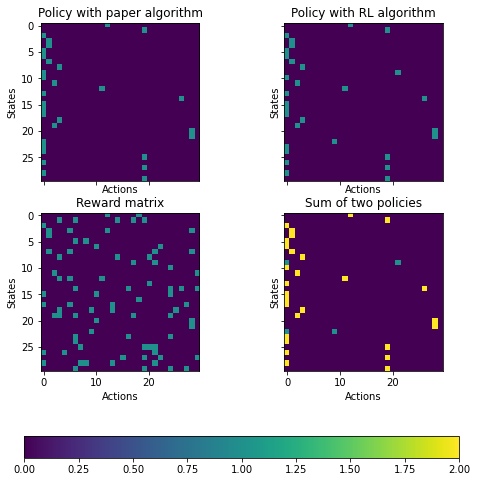

Similarity between Paper algorithm and RL algorithm : 0.9333333333333333


In [300]:
compare_algo(env, q_table, policy,cmap='viridis' )

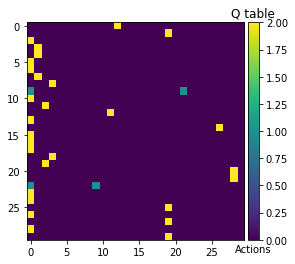

In [301]:
plot_q_table(get_final_table(q_table) + policy)